- Other approach
- Instead of focusing on all fires in an entire year, we focus on several firest that were covered well
- → Jueterbog / Luckenwalde
  - 2018/08/24: https://www.dw.com/en/forest-fires-near-berlin-could-burn-for-days/a-45203042
  - 2019
    - Fire in June ("einer der größten Brände der letzten Jahrzehnte") https://web.archive.org/web/20190622070809/https://www.rbb24.de/panorama/beitrag/2019/06/waldbrand-jueterbog-sonntag-lage-unter-kontrolle.html
    - Another fire in July https://web.archive.org/web/20190730000919/https://www.rbb24.de/panorama/beitrag/2019/07/loescharbeiten-jueterbog-truppenuebungsplatz-brandenburg.html

In [1]:
from datetime import date, timedelta
import os
from sentinel_helpers import search_osm, plot_all
from sentinelsat import SentinelAPI
from pathlib import Path
from tqdm.notebook import tqdm

api = SentinelAPI(os.getenv('SCIHUB_USERNAME'), os.getenv('SCIHUB_PASSWORD'))
api._tqdm = tqdm
out_dir = Path('input/forest_fires')

## 2018

- Take the places from the DW article
  - `.head(n=1)` takes the first search result, they are ordered by how well they match our query
- We don't have info on the exact time of the location, article is written on 2018-08-24

In [2]:
import geopandas as gpd
import pandas as pd
from sentinel_helpers import geodataframe_on_map

In [3]:
frohnsdorf = search_osm('Frohnsdorf, Brandenburg').head(n=1)
klausdorf = search_osm('Klausdorf, Brandenburg').head(n=1)
tiefenbrunnen = search_osm('Tiefenbrunnen, Brandenburg').head(n=1)

In [4]:
evacuated_places = gpd.GeoDataFrame(pd.concat([frohnsdorf, klausdorf, tiefenbrunnen]))
geodataframe_on_map(evacuated_places)

In [5]:
evacuated_places.to_file(out_dir / 'evacuated_2018.json', driver='GeoJSON')

In [6]:
from shapely.geometry import box

In [7]:
article_date = date(2018, 8, 24)
pre_fire_2018 = article_date - timedelta(weeks=4)
post_fire_2018 = article_date + timedelta(weeks=4)

In [8]:
footprint_2018 = box(*evacuated_places.to_crs('epsg:25833').buffer(2500).to_crs('epsg:4326').unary_union.bounds)
results = api.query(footprint_2018.wkt,
                    platformname='Sentinel-2',
                    processinglevel='Level-2A',
                    date=(pre_fire_2018, post_fire_2018),
                    cloudcoverpercentage=(0, 30))

/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<AxesSubplot:xlabel='beginposition'>

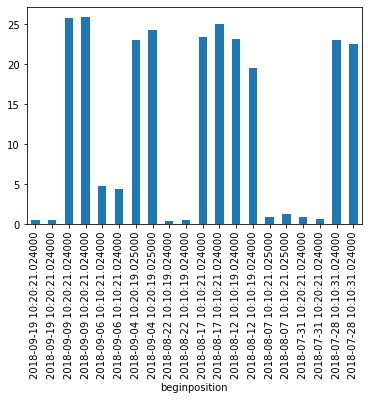

In [9]:
gdf = SentinelAPI.to_geodataframe(results)
gdf.set_index('beginposition')['cloudcoverpercentage'].plot(kind='bar')

- deduplicate the captured products
- avoid reprojecting, avoid merging

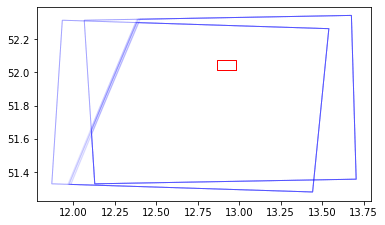

In [10]:
plot_all([
    gdf, footprint_2018
], [
    { 'facecolor': 'none', 'edgecolor': 'blue', 'alpha': 0.1 },
    { 'facecolor': 'none', 'edgecolor': 'red' }
])

- we can take any product because the all easily contain the study area

In [11]:
gdf['tile'] = gdf['title'].apply(lambda t: t.split('_')[5])
gdf['tile'].unique()

array(['T33UUT', 'T32UQC'], dtype=object)

<AxesSubplot:xlabel='beginposition'>

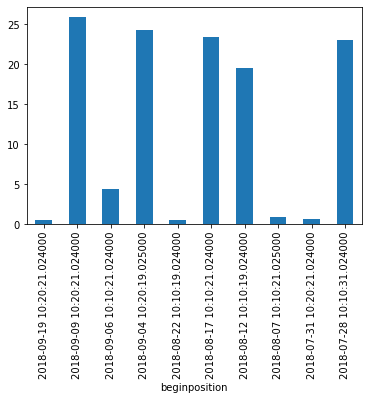

In [12]:
gdf = gdf[gdf['tile'] == 'T33UUT']
gdf.set_index('beginposition')['cloudcoverpercentage'].plot(kind='bar')

- from the plot we select the following timestamps:
  - criteria: low cloud coverage, close to before and after the fire
  - we don't know exactly how long it burned, so we take the last one as well

In [13]:
timestamps = [
    '2018-08-07 10:10:21.025000',
    '2018-08-22 10:10:19.024000',
    '2018-09-19 10:20:21.024000'
]
product_uuids_2018 = gdf[gdf['beginposition'].isin(timestamps)]['uuid'].values

In [14]:
out_dir.mkdir(exist_ok=True, parents=True)
downloaded, initialized, failed = api.download_all(product_uuids_2018, out_dir)

In [15]:
len(downloaded)

3

In [16]:
len(initialized)

0

In [17]:
len(failed)

0

- output paths:

In [18]:
list(map(lambda d: d['path'], downloaded.values()))

['input/forest_fires/S2B_MSIL2A_20180822T101019_N0208_R022_T33UUT_20180822T161243.zip',
 'input/forest_fires/S2A_MSIL2A_20180807T101021_N0208_R022_T33UUT_20180809T112302.zip',
 'input/forest_fires/S2A_MSIL2A_20180919T102021_N0208_R065_T33UUT_20180919T132226.zip']

## 2019

- Jueterbog
- https://web.archive.org/web/20190622070809/https://www.rbb24.de/panorama/beitrag/2019/06/waldbrand-jueterbog-sonntag-lage-unter-kontrolle.html
- Article date: 2019-06-19
  - Article says: fire is put out, fire fighting again responsibility of communities
  - "have been at work for one week"

In [19]:
jueterbog = search_osm('Jüterbog, Brandenburg')
jueterbog = jueterbog[(jueterbog['type'] == 'administrative') & (jueterbog['osm_type'] == 'relation')]
jueterbog

,place_id,osm_type,osm_id,display_name,place_rank,category,type,importance,icon,geometry
0,257891092,relation,422436,"Jüterbog, Teltow-Fläming, Brandenburg, 14913, ...",16,boundary,administrative,0.685236,https://nominatim.openstreetmap.org/ui/mapicon...,"POLYGON ((12.95605 52.03939, 12.96134 52.03944..."


In [20]:
geodataframe_on_map(jueterbog)

- we increase the geometry size by 2.5km in each direction

In [21]:
import geopandas as gpd

buffered = jueterbog.to_crs('epsg:25833').buffer(2500).to_crs('epsg:4326')
geodataframe_on_map(buffered)

- now we search for products in the relevant time frame

In [22]:
article_date = date(2019, 6, 16)
pre_fire_2019 = article_date - timedelta(weeks=4)
post_fire_2019 = article_date + timedelta(weeks=4)

In [23]:
footprint_2019 = buffered.iloc[0].convex_hull
results = api.query(footprint_2019.wkt,
                    platformname='Sentinel-2',
                    processinglevel='Level-2A',
                    date=(pre_fire_2019, post_fire_2019),
                    cloudcoverpercentage=(0, 30))

/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<AxesSubplot:xlabel='beginposition'>

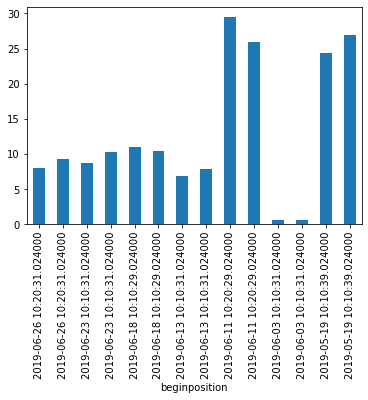

In [24]:
gdf = SentinelAPI.to_geodataframe(results)
gdf.set_index('beginposition')['cloudcoverpercentage'].plot(kind='bar')

- how well do the results cover our study area?

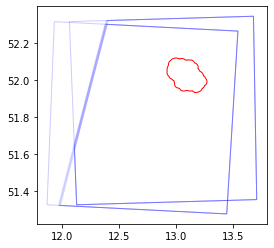

In [25]:
plot_all([
    gdf, buffered
], [
    { 'facecolor': 'none', 'edgecolor': 'blue', 'alpha': 0.1 },
    { 'facecolor': 'none', 'edgecolor': 'red' }
])

- again, well!

<AxesSubplot:xlabel='beginposition'>

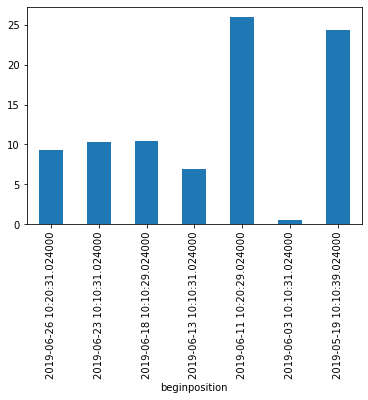

In [26]:
gdf['tile'] = gdf['title'].apply(lambda t: t.split('_')[5])
gdf = gdf[gdf['tile'] == 'T33UUT']
gdf.set_index('beginposition')['cloudcoverpercentage'].plot(kind='bar')

In [27]:
timestamps = [
    '2019-06-03 10:10:31.024000', # before the fire, almost no clouds
    '2019-06-13 10:10:31.024000', # during the fire?
    '2019-06-26 10:20:31.024000', # after the fire, within cloud coverage < 30%
]
product_uuids_2019 = gdf[gdf['beginposition'].isin(timestamps)]['uuid'].values

In [28]:
downloaded, initialized, failed = api.download_all(product_uuids_2019, out_dir)

In [29]:
len(downloaded)

3

In [30]:
len(initialized)

0

In [31]:
len(failed)

0

In [32]:
failed

{}

- originally downloaded: 0, initialized: 1, failed: 2
- failed product with uuid `1e9358eb-2c1e-45a5-aabd-ee7b193eda0e` has status code `202 Accepted`, so not actually failed?
- all products could be downloaded within 5 hours


- output paths

In [33]:
list(map(lambda d: d['path'], downloaded.values()))

['input/forest_fires/S2A_MSIL2A_20190613T101031_N0212_R022_T33UUT_20190614T125329.zip',
 'input/forest_fires/S2A_MSIL2A_20190603T101031_N0212_R022_T33UUT_20190603T114652.zip',
 'input/forest_fires/S2A_MSIL2A_20190626T102031_N0212_R065_T33UUT_20190626T125319.zip']